# Quantum-chemical property prediction with GNNs

In this `mlx-graphs` tutorial we explore how to use and graph neural networks to predict quantum-chemical properties of small molecules. You may need to install `mlx`, `mlx-graphs`, `tqdm` and `matplotlib` to run it.

## Loading the dataset
We will be using the QM9 dataset as provided via `TUDataset`, which consists of about 130,000 small molecules consisting of 9 heavy atoms drawn from the elements C, H, O, N, F. Each molecule includes  spatial information for the single low energy conformation (i.e., 3D coordinates of the atoms, specified in the latest 3 columns in the `node_features` of the graph) in addition to 13 other features.  The dataset consists of 19 regression tasks, corresponding to different quantum-chemical properties of the molecules.

Let's start by loading the dataset and looking at some of its properties

In [1]:
from mlx_graphs.datasets import TUDataset
qm9 = TUDataset(name="QM9")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84.7M/84.7M [00:08<00:00, 10.4MB/s]


Extracting file to /Users/tgg/Github/mlx-graphs/docs/source/tutorials/examples/.mlx_graphs_data/QM9/raw


In [2]:
print(f"Number of graphs: {len(qm9)}")
print(f"Number of node features: {qm9.num_node_features}")
print(f"Number of edge features: {qm9.num_edge_features}")
print(f"Number of regression tasks: {qm9[0].graph_labels.shape[1]}")

Number of graphs: 129433
Number of node features: 16
Number of edge features: 4
Number of regression tasks: 19


We'll split the dataset into training and test sets and create dataloader for them

In [25]:
from mlx_graphs.loaders import Dataloader

# training and test splits
num_training_samples = 110000

training_dataset = qm9[:num_training_samples]
test_dataset = qm9[num_training_samples:]

# dataloaders
batch_size = 128

train_loader = Dataloader(training_dataset, batch_size=batch_size, shuffle=True)
test_loader = Dataloader(test_dataset, batch_size=batch_size, shuffle=False)

In [26]:
len(test_dataset), len(training_dataset)

(19433, 110000)

## Graph Neural Network module
To dive a bit deeper into the GNN logic and allow for more flexibility, we will implement node and edge processing blocks from scratch (as in https://arxiv.org/pdf/1806.01261.pdf) and then combine them through the `GraphNetworkBlock` provided by `mlx-graphs`.

Let's start with the edge features update model. It will concatenate the `edge_features` with the `node_features` of the coreesponding source and target nodes, pass them through a simple MLP (just a linear layer followed by a ReLU) and output the updated `edge_features`.

In [4]:
import mlx.core as mx
import mlx.nn as nn
from mlx_graphs.nn import Linear
from mlx_graphs.utils import scatter

In [15]:
class EdgeModel(nn.Module):
    def __init__(
        self,
        edge_features_dim: int,
        node_features_dim: int,
        output_dim: int,
    ):
        super().__init__()
        self.linear = Linear(
            input_dims=2 * node_features_dim + edge_features_dim, # source + target features + edge features
            output_dims=output_dim,
        )

    def __call__(
        self,
        edge_index: mx.array,
        node_features: mx.array,
        edge_features: mx.array,
        graph_features = None
    ):
        source_nodes = edge_index[0]
        destination_nodes = edge_index[1]
        model_input = mx.concatenate(
            [
                node_features[destination_nodes],
                node_features[source_nodes],
                edge_features,
            ],
            1,
        )
        new_edge_features = self.linear(model_input)
        new_edge_features = nn.leaky_relu(new_edge_features)
        return new_edge_features

The node features update model will start by aggregating the `edge_features` corresponding to the edges incoming into each node, by computing their mean. Such aggregated edge features will be concatenated to the corresponding `node_features` and passed through an MLP to compute the updated node features.

In [16]:
class NodeModel(nn.Module):
    def __init__(
        self,
        node_features_dim: int,
        edge_features_dim: int,
        output_dim: int,
    ):
        super().__init__()
        self.linear = Linear(
            input_dims=node_features_dim + edge_features_dim,
            output_dims=output_dim,
        )

    def __call__(
        self,
        edge_index: mx.array,
        node_features: mx.array,
        edge_features: mx.array,
        graph_features = None
    ):
        target_nodes = edge_index[1]
        aggregated_edges = scatter(edge_features, target_nodes, out_size=node_features.shape[0], aggr="max")
        model_input = mx.concatenate([node_features, aggregated_edges], 1)
        new_node_features = self.linear(model_input)
        new_node_features = nn.leaky_relu(new_node_features)
        return new_node_features

Now, the edge and node models we defined can be combined to create a basic graph neural network to sequentially update/transform edges and node features of the input graph. 

To do that we can use the `GraphNetworkBlock`. In the model below we create two graph network blocks that we apply sequentially, we then pool the node features and pass them through a linear transformation to compute the predicted output. We use an output dimension of 1 for the entire model as we'll use it to learn a single regression task.

In [17]:
from mlx_graphs.nn import global_mean_pool, GraphNetworkBlock


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.gnn1 = GraphNetworkBlock(
            node_model=NodeModel(qm9.num_node_features, 64, 64), 
            edge_model=EdgeModel(qm9.num_edge_features, qm9.num_node_features, 64),
        )
        self.gnn2 = GraphNetworkBlock(
            node_model=NodeModel(64, 64, 64), 
            edge_model=EdgeModel(64, 64, 64),
        )
        self.output_linear = Linear(input_dims=64, output_dims=1)
        
    def __call__(
        self,
        edge_index: mx.array,
        node_features: mx.array,
        edge_features: mx.array,
        batch_indices: mx.array,
    ):
        
        node_features, edge_features, _ = self.gnn1(
            edge_index=data.edge_index,
            node_features=data.node_features,
            edge_features=data.edge_features,
        )
        node_features, _, _ = self.gnn2(
            edge_index=data.edge_index,
            node_features=node_features,
            edge_features=edge_features,
        )
        out = global_mean_pool(node_features, batch_indices)
        return self.output_linear(out)
        

## Model training
Now that we have our model we can simply define our loss function (MSE) and the forward function we're going to use to train our model along with an optimizer (we'll use AdamW in this example).

In [18]:
import mlx.optimizers as optim

model = Model()

mx.eval(model.parameters())

def loss_fn(y_hat, y, parameters=None):
    return nn.losses.mse_loss(y_hat, y, "sum")

def forward_fn(model, graph, labels):
    y_hat = model(graph.edge_index, graph.node_features, graph.edge_features, graph.batch_indices)
    loss = loss_fn(y_hat, labels, model.parameters())
    return loss, y_hat

loss_and_grad_fn = nn.value_and_grad(model, forward_fn)
optimizer = optim.AdamW(learning_rate=1e-3)

We're now ready to train our GNN model. Let's select the "Lowest unoccupied molecular orbital energy" as the target regression task.

In [21]:
from tqdm import tqdm

mx.set_default_device(mx.gpu)
regression_task = 4
    
len_training_loader = int(len(training_dataset)/batch_size + 1)
len_test_loader = int(len(test_dataset)/batch_size + 1)
epochs = 20

epoch_training_losses = []
epoch_test_losses = []
for epoch in range(epochs):
    # training loop
    with tqdm(train_loader, total=len_training_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch + 1}")
        training_loss = 0.0
        for idx, data in enumerate(tepoch):
            (loss, y_hat), grads = loss_and_grad_fn(
                model=model,
                graph=data,
                labels=mx.expand_dims(data.graph_labels[:, regression_task], 1),
            )
            optimizer.update(model, grads)
            mx.eval(model.parameters(), optimizer.state)
            training_loss += loss.item()/data.num_graphs
            tepoch.set_postfix(training_loss=training_loss / (idx+1), test_loss=0)
        epoch_training_losses.append(training_loss/(idx+1))

    # testing loop
    with tqdm(test_loader, total=len_test_loader, unit="batch", leave=False) as test_epoch:
        test_epoch.set_description(f"Testing")
        test_loss = 0.0
        for idx, data in enumerate(test_epoch):
            y_hat = model(data.edge_index, data.node_features, data.edge_features, data.batch_indices)
            loss = loss_fn(y_hat, mx.expand_dims(data.graph_labels[:, regression_task], 1))
            test_loss += loss.item()/data.num_graphs
            test_epoch.set_postfix(test_loss=test_loss / (idx+1))
        epoch_test_losses.append(test_loss/(idx+1))

Epoch 20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 860/860 [00:06<00:00, 136.94batch/s, test_loss=0, training_loss=0.115]


!mamba install matplotlib -y

Now that the training is concluded we can visualize the evolution of the training and test losses.

In [13]:
import matplotlib.pyplot as plt

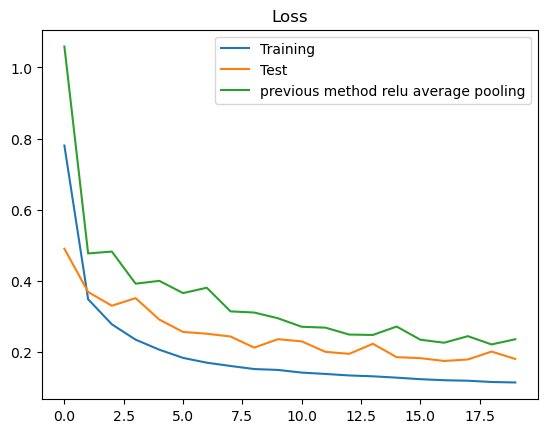

In [22]:
plt.figure()
plt.plot(range(epochs), epoch_training_losses, label="Training")
plt.plot(range(epochs), epoch_test_losses, label="Test")
plt.plot(range(epochs), v1, label="previous method relu average pooling")

plt.title("Loss")
plt.legend()
plt.show()

## Notes and next steps
While this is an illustrative tutorial, we hope it gives some insights into `mlx-graphs`. Next steps could involve implementing more complex and specialized models (e.g., exploiting invariances and equivariances in the geometries of the molecules) or normalizing features and target properties, which can highly improve performance as well.

In [20]:
v1  = epoch_test_losses